In [1]:
# Configure anaconda environment
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:41
🔁 Restarting kernel...


In [1]:
# Install RDKit. Takes 2-3 minutes
%%capture
!mamba install -c conda-forge rdkit

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/My Drive/Molecular_Property_Prediction_project

Mounted at /content/drive
/content/drive/My Drive/Molecular_Property_Prediction_project


In [ ]:
# Install latest version of nfp
%%capture
!pip install nfp==0.2.1

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, utils
print(f"tensorflow {tf.__version__}")

import nfp
print(f"nfp {nfp.__version__}")

tensorflow 2.5.0
nfp 0.2.1


In [29]:
baceDF = pd.read_csv('./data/bace.csv')

# Split the data into training, validation, and test sets
train, valid, test =    baceDF[baceDF["Model"] == "Train"].mol.to_numpy(), \
                        baceDF[baceDF["Model"] == "Valid"].mol.to_numpy(), \
                        baceDF[baceDF["Model"] == "Test"].mol.to_numpy()

In [30]:
# Define how to featurize the input molecules
def atom_featurizer(atom):
    """ Return an string representing the atom type """

    return str((
        atom.GetSymbol(),
        atom.GetDegree(),
        atom.GetFormalCharge(),
        atom.GetNumRadicalElectrons(),
        atom.GetIsAromatic(),
        nfp.get_ring_size(atom, max_size=6),
        atom.GetTotalNumHs(includeNeighbors=True)
    ))


def bond_featurizer(bond, flipped=False):
    """ Get a similar classification of the bond type.
    Flipped indicates which 'direction' the bond edge is pointing. """

    if not flipped:
        atoms = "{}-{}".format(
            *tuple((bond.GetBeginAtom().GetSymbol(),
                    bond.GetEndAtom().GetSymbol())))
    else:
        atoms = "{}-{}".format(
            *tuple((bond.GetEndAtom().GetSymbol(),
                    bond.GetBeginAtom().GetSymbol())))

    btype = str(bond.GetBondType())
    ring = 'R{}'.format(nfp.get_ring_size(bond, max_size=6)) if bond.IsInRing() else ''

    return " ".join([atoms, btype, ring]).strip()


preprocessor = nfp.SmilesPreprocessor(atom_features=atom_featurizer,
                                      bond_features=bond_featurizer,
                                      explicit_hs=False)

# Initially, the preprocessor has no data on atom types, so we have to loop over the
# training set once to pre-allocate these mappings
for smiles in train:
    preprocessor.construct_feature_matrices(smiles, train=True)

In [31]:
# Essentially, this is responsible for calling the input constructor, batching
# together multiple molecules, and padding the resulting molecules so that all
# molecules in the same batch have the same number of atoms (we pad with zeros,
# hence why the atom and bond types above start with 1 as the unknown class)

train_dataset = tf.data.Dataset.from_generator(
    lambda: ((preprocessor.construct_feature_matrices(row.mol, train=False),
              {'qualitative_label': row.Class, 'quantitative_label': row.pIC50}) for i, row in
             baceDF[baceDF.mol.isin(train)].iterrows()),
    output_types=(preprocessor.output_types, {'qualitative_label': tf.int32, 'quantitative_label': tf.float32}),
    output_shapes=(preprocessor.output_shapes, {'qualitative_label': [], 'quantitative_label': []})) \
    .cache().shuffle(buffer_size=200) \
    .padded_batch(batch_size=64,
                  padded_shapes=(preprocessor.padded_shapes(), {'qualitative_label': [], 'quantitative_label': []}),
                  padding_values=(preprocessor.padding_values, {'qualitative_label': 0, 'quantitative_label': 0.})) \
    .prefetch(tf.data.experimental.AUTOTUNE)\
    .repeat()


valid_dataset = tf.data.Dataset.from_generator(
    lambda: ((preprocessor.construct_feature_matrices(row.mol, train=False),
              {'qualitative_label': row.Class, 'quantitative_label': row.pIC50}) for i, row in
             baceDF[baceDF.mol.isin(valid)].iterrows()),
    output_types=(preprocessor.output_types, {'qualitative_label': tf.int32, 'quantitative_label': tf.float32}),
    output_shapes=(preprocessor.output_shapes, {'qualitative_label': [], 'quantitative_label': []})) \
    .cache().shuffle(buffer_size=200) \
    .padded_batch(batch_size=64,
                  padded_shapes=(preprocessor.padded_shapes(), {'qualitative_label': [], 'quantitative_label': []}),
                  padding_values=(preprocessor.padding_values, {'qualitative_label': 0, 'quantitative_label': 0.}))\
    .prefetch(tf.data.experimental.AUTOTUNE)\
    .repeat()

# Model #1

In [32]:
## Model

# Input layers
atom = layers.Input(shape=[None], dtype=tf.int64, name='atom')
bond = layers.Input(shape=[None], dtype=tf.int64, name='bond')
connectivity = layers.Input(shape=[None, 2], dtype=tf.int64, name='connectivity')

num_features = 128  # Controls the size of the model

# Convert from a single integer defining the atom state to a vector of weights associated with that class
atom_state = layers.Embedding(preprocessor.atom_classes, num_features, name='atom_embedding', mask_zero=True)(atom)

# Ditto with the bond state
bond_state = layers.Embedding(preprocessor.bond_classes, num_features, name='bond_embedding', mask_zero=True)(bond)

# Here we use our first nfp layer. This is an attention layer that looks at
# the atom and bond states and reduces them to a single, graph-level vector.
# num_heads * units has to be the same dimension as the atom / bond dimension
global_state = nfp.GlobalUpdate(units=8, num_heads=1)([atom_state, bond_state, connectivity])

for _ in range(3):  # Do the message passing
    new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity, global_state])
    bond_state = layers.Add()([bond_state, new_bond_state])

    new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity, global_state])
    atom_state = layers.Add()([atom_state, new_atom_state])

    new_global_state = nfp.GlobalUpdate(units=8, num_heads=1)(
        [atom_state, bond_state, connectivity, global_state])
    global_state = layers.Add()([global_state, new_global_state])

# Since the final prediction is a single, molecule-level property (pIC50), we reduce the last global state to a single prediction.
Class_prediction = layers.Dense(1, name='qualitative_label', activation="sigmoid")(global_state)
pIC50_prediction = layers.Dense(1, name='quantitative_label', activation="relu")(global_state)

# Construct the tf.keras model
model = tf.keras.Model(inputs=[atom, bond, connectivity], outputs=[Class_prediction, pIC50_prediction])
#utils.plot_model(model, "BACE-1 predictor.png", show_shapes=True)

model.compile(optimizer=tf.keras.optimizers.Adam(1E-3), 
              loss={'qualitative_label': 'binary_crossentropy',
                    'quantitative_label': 'mean_squared_error'}, 
              metrics={'qualitative_label': ['accuracy', tf.keras.metrics.AUC(name="auc")]})

In [33]:
history = model.fit(train_dataset,
                    steps_per_epoch=len(train) // 64,
                    validation_data=valid_dataset,
                    validation_steps=1,
                    epochs=250,
                    verbose=1)

Epoch 1/250


/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['n_atom', 'n_bond', 'bond_indices'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


3/3 [==============================] - 14s 2s/step - loss: 45.6781 - qualitative_label_loss: 0.8870 - quantitative_label_loss: 44.7910 - qualitative_label_accuracy: 0.4740 - qualitative_label_auc: 0.4561 - val_loss: 48.6727 - val_qualitative_label_loss: 0.7554 - val_quantitative_label_loss: 47.9173 - val_qualitative_label_accuracy: 0.2656 - val_qualitative_label_auc: 0.6083
Epoch 2/250
3/3 [==============================] - 3s 1s/step - loss: 31.6641 - qualitative_label_loss: 0.7683 - quantitative_label_loss: 30.8957 - qualitative_label_accuracy: 0.4358 - qualitative_label_auc: 0.5387 - val_loss: 9.5438 - val_qualitative_label_loss: 1.3072 - val_quantitative_label_loss: 8.2367 - val_qualitative_label_accuracy: 0.2969 - val_qualitative_label_auc: 0.6322
Epoch 3/250
3/3 [==============================] - 3s 1s/step - loss: 6.0795 - qualitative_label_loss: 0.7933 - quantitative_label_loss: 5.2863 - qualitative_label_accuracy: 0.4749 - qualitative_label_auc: 0.6611 - val_loss: 3.7308 - val

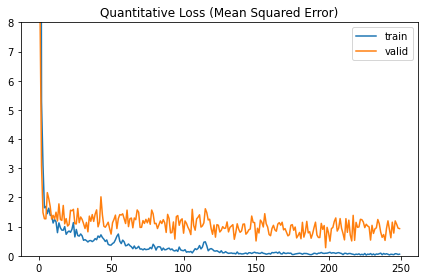

In [34]:
plt.title('Quantitative Loss (Mean Squared Error)')
plt.plot(history.history['quantitative_label_loss'], label='train')
plt.plot(history.history['val_quantitative_label_loss'], label='valid')
plt.legend()
plt.ylim(0,8)
plt.tight_layout()

plt.savefig('imgs/Model-1/Quantitative Loss.png')
plt.show()
plt.close()

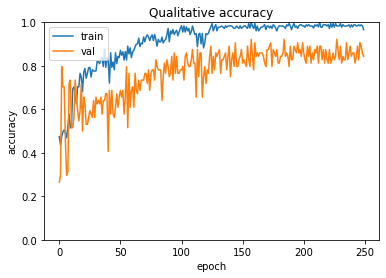

In [35]:
plt.title('Qualitative accuracy')
plt.plot(history.history['qualitative_label_accuracy'])
plt.plot(history.history['val_qualitative_label_accuracy'])
plt.ylim(0,1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.savefig('imgs/Model-1/Qualitative Accuracy.png')
plt.show()
plt.close()

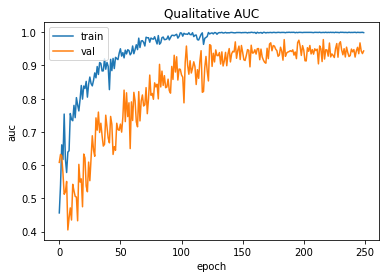

In [36]:
plt.title('Qualitative AUC')
plt.plot(history.history['qualitative_label_auc'])
plt.plot(history.history['val_qualitative_label_auc'])
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.savefig('imgs/Model-1/Qualitative AUC.png')
plt.show()
plt.close()

In [37]:
# Here, we create a test dataset that doesn't assume we know the values for the pIC50

test_dataset = tf.data.Dataset.from_generator(
    lambda: ((preprocessor.construct_feature_matrices(row.mol, train=False),
              {'qualitative_label': row.Class, 'quantitative_label': row.pIC50}) for i, row in
             baceDF[baceDF.mol.isin(test)].iterrows()),
    output_types=(preprocessor.output_types, {'qualitative_label': tf.int32, 'quantitative_label': tf.float32}),
    output_shapes=(preprocessor.output_shapes, {'qualitative_label': [], 'quantitative_label': []})) \
    .cache().shuffle(buffer_size=200) \
    .padded_batch(batch_size=64,
                  padded_shapes=(preprocessor.padded_shapes(), {'qualitative_label': [], 'quantitative_label': []}),
                  padding_values=(preprocessor.padding_values, {'qualitative_label': 0, 'quantitative_label': 0.}))\
    .prefetch(tf.data.experimental.AUTOTUNE)\


loss, qualitative_label_loss, quantitative_label_loss, qualitative_label_accuracy, qualitative_label_auc = model.evaluate(test_dataset, verbose=0)

In [38]:
print(f"Qualitative accuracy on test: \t{qualitative_label_accuracy}")
print(f"Qualitative AUC on test: \t{qualitative_label_auc}")
print(f"Mean Squared Error on test: \t{quantitative_label_loss}")

Qualitative accuracy on test: 	0.6284584999084473
Qualitative AUC on test: 	0.7003774642944336
Mean Squared Error on test: 	1.4411540031433105


# Model #2

In [ ]:
baceDF = pd.read_csv('data/bace.csv')

# Split the data into training, validation, and test sets
train, valid, test =    baceDF[baceDF["Model"] == "Test"].mol.to_numpy(), \
                        baceDF[baceDF["Model"] == "Valid"].mol.to_numpy(), \
                        baceDF[baceDF["Model"] == "Train"].mol.to_numpy()

203 45 1265


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1E-3), 
              loss={'qualitative_label': 'binary_crossentropy',
                    'quantitative_label': 'mean_squared_error'}, 
              metrics={'qualitative_label': ['accuracy', tf.keras.metrics.AUC(name="auc")]})

history = model.fit(train_dataset,
                    steps_per_epoch=len(train) // 64,
                    validation_data=valid_dataset,
                    validation_steps=1,
                    epochs=250,
                    verbose=1)

Epoch 1/250


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['n_atom', 'n_bond', 'bond_indices'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


19/19 [==============================] - 22s 789ms/step - loss: 17.7418 - qualitative_label_loss: 1.2015 - quantitative_label_loss: 16.5403 - qualitative_label_accuracy: 0.5592 - qualitative_label_auc_4: 0.6749 - val_loss: 6.6989 - val_qualitative_label_loss: 0.9242 - val_quantitative_label_loss: 5.7748 - val_qualitative_label_accuracy: 0.5312 - val_qualitative_label_auc_4: 0.4485
Epoch 2/250
19/19 [==============================] - 10s 559ms/step - loss: 2.9787 - qualitative_label_loss: 1.1606 - quantitative_label_loss: 1.8181 - qualitative_label_accuracy: 0.5462 - qualitative_label_auc_4: 0.2538 - val_loss: 6.1202 - val_qualitative_label_loss: 0.8076 - val_quantitative_label_loss: 5.3126 - val_qualitative_label_accuracy: 0.5469 - val_qualitative_label_auc_4: 0.5039
Epoch 3/250
19/19 [==============================] - 10s 551ms/step - loss: 3.7875 - qualitative_label_loss: 0.9919 - quantitative_label_loss: 2.7956 - qualitative_label_accuracy: 0.5504 - qualitative_label_auc_4: 0.1946 -

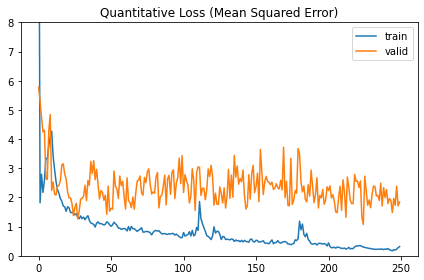

In [ ]:
plt.title('Quantitative Loss (Mean Squared Error)')
plt.plot(history.history['quantitative_label_loss'], label='train')
plt.plot(history.history['val_quantitative_label_loss'], label='valid')
plt.legend()
plt.ylim(0,8)
plt.tight_layout()

plt.savefig('imgs/Model-2/Quantitative Loss.png')
plt.show()
plt.close()

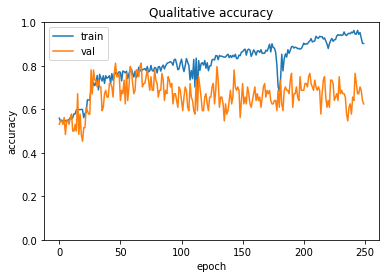

In [ ]:
plt.title('Qualitative accuracy')
plt.plot(history.history['qualitative_label_accuracy'])
plt.plot(history.history['val_qualitative_label_accuracy'])
plt.ylim(0,1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.savefig('imgs/Model-2/Qualitative Accuracy.png')
plt.show()
plt.close()

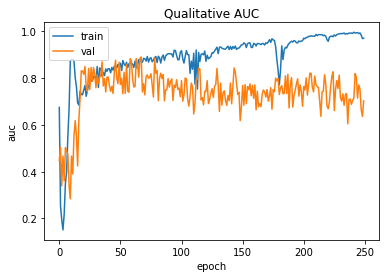

In [ ]:
plt.title('Qualitative AUC')
plt.plot(history.history['qualitative_label_auc_4'])
plt.plot(history.history['val_qualitative_label_auc_4'])
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.savefig('imgs/Model-2/Qualitative AUC.png')
plt.show()
plt.close()

In [ ]:
# Here, we create a test dataset that doesn't assume we know the values for the pIC50

test_dataset = tf.data.Dataset.from_generator(
    lambda: ((preprocessor.construct_feature_matrices(row.mol, train=False),
              {'qualitative_label': row.Class, 'quantitative_label': row.pIC50}) for i, row in
             baceDF[baceDF.mol.isin(test)].iterrows()),
    output_types=(preprocessor.output_types, {'qualitative_label': tf.int32, 'quantitative_label': tf.float32}),
    output_shapes=(preprocessor.output_shapes, {'qualitative_label': [], 'quantitative_label': []})) \
    .cache().shuffle(buffer_size=200) \
    .padded_batch(batch_size=64,
                  padded_shapes=(preprocessor.padded_shapes(), {'qualitative_label': [], 'quantitative_label': []}),
                  padding_values=(preprocessor.padding_values, {'qualitative_label': 0, 'quantitative_label': 0.}))\
    .prefetch(tf.data.experimental.AUTOTUNE)\


loss, qualitative_label_loss, quantitative_label_loss, qualitative_label_accuracy, qualitative_label_auc = model.evaluate(test_dataset, verbose=0)

In [ ]:
print(f"Qualitative accuracy on test: \t{qualitative_label_accuracy}")
print(f"Qualitative AUC on test: \t{qualitative_label_auc}")
print(f"Mean Squared Error on test: \t{quantitative_label_loss}")

Qualitative accuracy on test: 	0.674876868724823
Qualitative AUC on test: 	0.7496117353439331
Mean Squared Error on test: 	1.8264555931091309
